<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [47]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [48]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [49]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [50]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [51]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [52]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  print((1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]))
  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

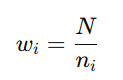

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [53]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [54]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 3:
    googlenet = models.googlenet(weights="IMAGENET1K_V1")
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 4:
    efficientnet = models.efficientnet_b3(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.fc.in_features
    efficientnet.fc = nn.Linear(in_features=num_features, out_features=1)
    return efficientnet,loss_fn

  elif numero_model == 5:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  elif numero_model == 6:

    resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass.fc.in_features
    resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass,loss_fn

  elif numero_model == 7:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 8:

    googlenetmulticlass = models.googlenet(weights="IMAGENET1K_V1")

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 9:

    efficientnetmulticlass = models.efficientnet_b3(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [55]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [56]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [57]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [58]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 10
  requerit = 0.015
  last_f1 = 0

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_f1 + requerit > train_f1:
            torch.save(model.state_dict(), 'best_model.pt')
            print("Early Stopping, no hem pujat ni un 2% d'f1-score respecte 10 èpoques!!")
            break
        else:
          interval = 10
          last_f1 = train_f1


  wandb.finish()

In [59]:
def test(model,dataloader,weights_dir,loss_fn,device):
  model.load_state_dict(torch.load(weights_dir))
  test_acc,test_f1,test_recall,test_precision,test_loss  = validate(model,loss_fn,dataloader,device)

  if WEIGHTSANDBIASES:
    test_metrics = {"test/test_loss": test_loss/len(dataloader),
                      "test/test_acc":test_acc/len(dataloader),
                      "test/test_f1":test_f1/len(dataloader),
                      "test/test_recall": test_recall/len(dataloader),
                      "test/test_precision": test_precision/len(dataloader)}

    wandb.log({**test_metrics})

In [60]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2,'googlenet':3,'efficientnet':4,'alexnetmulticlass':5,'resnet50multiclass':6,'resnet150multiclass':7,'googlenetmulticlass':8,'efficientnetmulticlass':9}
MODEL = architectures['resnet']

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
increment = 1.0
binary_weights, multiple_weights = get_weights()

if MODEL < 5:
  WEIGHTS = [binary_weights]
  print(WEIGHTS)
else:
  WEIGHTS = [multiple_weights]


learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary','Ham10000-GoogleNetBinary','Ham10000-EfficientNetBinary',
               'Ham10000-AlexnetMulticlass','Ham10000ResnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-GoogleNetMulticlass','Ham10000-EfficientNetMulticlass']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
  test(model,test_loader,"/content/best_model.pt",loss_fn,device)

0    5363
1     891
2     879
3     411
4     261
5     114
6      92
Name: count, dtype: int64
8011
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
2.845929572315279
[2.845929572315279]
{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [2.845929572315279]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.6456756672536235
Accuracy train epoch: 1  train_acc: 0.7800276168055053
F1 train epoch: 1  train_f1: 0.7945383701158376
Recall train epoch: 1  train_recall: 0.7800276168055053


Pèrdua validació epoch: 1  val_loss: 0.5439686179161072
Accuracy val epoch: 1  val_acc: 0.8181640625
F1 val epoch: 1  val_f1: 0.8305867486416674
Recall val epoch: 1  val_recall: 0.8181640625
Recall val epoch: 1  val_precision: 0.8638809184262858


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.5346425005876686
Accuracy train epoch: 2  train_acc: 0.8193928830134009
F1 train epoch: 2  train_f1: 0.832732236873419
Recall train epoch: 2  train_recall: 0.8193928830134009


Pèrdua validació epoch: 2  val_loss: 0.526542417705059
Accuracy val epoch: 2  val_acc: 0.793359375
F1 val epoch: 2  val_f1: 0.8142380060111212
Recall val epoch: 2  val_recall: 0.793359375
Recall val epoch: 2  val_precision: 0.876003656191298


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.5065876006842609
Accuracy train epoch: 3  train_acc: 0.8312205722564288
F1 train epoch: 3  train_f1: 0.8428057382729539
Recall train epoch: 3  train_recall: 0.8312205722564288


Pèrdua validació epoch: 3  val_loss: 0.4920448246411979
Accuracy val epoch: 3  val_acc: 0.824609375
F1 val epoch: 3  val_f1: 0.8392119129962664
Recall val epoch: 3  val_recall: 0.824609375
Recall val epoch: 3  val_precision: 0.8767936490592741


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.4813329551324426
Accuracy train epoch: 4  train_acc: 0.8445196486780152
F1 train epoch: 4  train_f1: 0.8555057382806027
Recall train epoch: 4  train_recall: 0.8445196486780152


Pèrdua validació epoch: 4  val_loss: 0.4925801861099899
Accuracy val epoch: 4  val_acc: 0.8580078125
F1 val epoch: 4  val_f1: 0.8633250255019058
Recall val epoch: 4  val_recall: 0.8580078125
Recall val epoch: 4  val_precision: 0.8744697933422882


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.46581107336448957
Accuracy train epoch: 5  train_acc: 0.8497374139804419
F1 train epoch: 5  train_f1: 0.8596507040669005
Recall train epoch: 5  train_recall: 0.8497374139804419


Pèrdua validació epoch: 5  val_loss: 0.4931909069418907
Accuracy val epoch: 5  val_acc: 0.8677734375
F1 val epoch: 5  val_f1: 0.867867890252978
Recall val epoch: 5  val_recall: 0.8677734375
Recall val epoch: 5  val_precision: 0.8801431001723972


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.4408078339114132
Accuracy train epoch: 6  train_acc: 0.8576942231075697
F1 train epoch: 6  train_f1: 0.8678541416781762
Recall train epoch: 6  train_recall: 0.8576942231075697


Pèrdua validació epoch: 6  val_loss: 0.4747274979017675
Accuracy val epoch: 6  val_acc: 0.858984375
F1 val epoch: 6  val_f1: 0.863796549850334
Recall val epoch: 6  val_recall: 0.858984375
Recall val epoch: 6  val_precision: 0.8834427663899453


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.42813048965902445
Accuracy train epoch: 7  train_acc: 0.8611802788844621
F1 train epoch: 7  train_f1: 0.8703567781400728
Recall train epoch: 7  train_recall: 0.8611802788844621


Pèrdua validació epoch: 7  val_loss: 0.48147041257470846
Accuracy val epoch: 7  val_acc: 0.84765625
F1 val epoch: 7  val_f1: 0.8547269656302661
Recall val epoch: 7  val_recall: 0.84765625
Recall val epoch: 7  val_precision: 0.8740124499877389


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.4130474789684037
Accuracy train epoch: 8  train_acc: 0.8696577327055415
F1 train epoch: 8  train_f1: 0.8779985597645057
Recall train epoch: 8  train_recall: 0.8696577327055415


Pèrdua validació epoch: 8  val_loss: 0.45292433677241206
Accuracy val epoch: 8  val_acc: 0.8689453125
F1 val epoch: 8  val_f1: 0.8734069601519928
Recall val epoch: 8  val_recall: 0.8689453125
Recall val epoch: 8  val_precision: 0.8882954812992586


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.389883511094933
Accuracy train epoch: 9  train_acc: 0.8773768562115175
F1 train epoch: 9  train_f1: 0.8850451776008028
Recall train epoch: 9  train_recall: 0.8773768562115175


Pèrdua validació epoch: 9  val_loss: 0.44770346116274595
Accuracy val epoch: 9  val_acc: 0.8669921875
F1 val epoch: 9  val_f1: 0.8763155944226021
Recall val epoch: 9  val_recall: 0.8669921875
Recall val epoch: 9  val_precision: 0.8992529616588696


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3911667578367598
Accuracy train epoch: 10  train_acc: 0.8781465048895327
F1 train epoch: 10  train_f1: 0.8848740835469266
Recall train epoch: 10  train_recall: 0.8781465048895327


Pèrdua validació epoch: 10  val_loss: 0.4746475846040994
Accuracy val epoch: 10  val_acc: 0.8798828125
F1 val epoch: 10  val_f1: 0.8805969280176311
Recall val epoch: 10  val_recall: 0.8798828125
Recall val epoch: 10  val_precision: 0.8911804365603445


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.36127855581235124
Accuracy train epoch: 11  train_acc: 0.8868616443317638
F1 train epoch: 11  train_f1: 0.8935610708237817
Recall train epoch: 11  train_recall: 0.8868616443317638


Pèrdua validació epoch: 11  val_loss: 0.43759275041520596
Accuracy val epoch: 11  val_acc: 0.8806640625
F1 val epoch: 11  val_f1: 0.8829856500001291
Recall val epoch: 11  val_recall: 0.8806640625
Recall val epoch: 11  val_precision: 0.8905179363919451


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.34446831697605523
Accuracy train epoch: 12  train_acc: 0.8940601231437885
F1 train epoch: 12  train_f1: 0.9009902449817352
Recall train epoch: 12  train_recall: 0.8940601231437885


Pèrdua validació epoch: 12  val_loss: 0.5422673793509603
Accuracy val epoch: 12  val_acc: 0.8845703125
F1 val epoch: 12  val_f1: 0.8772849126225765
Recall val epoch: 12  val_recall: 0.8845703125
Recall val epoch: 12  val_precision: 0.887370075720136


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.34280525426940617
Accuracy train epoch: 13  train_acc: 0.8950448207171314
F1 train epoch: 13  train_f1: 0.9008640936973222
Recall train epoch: 13  train_recall: 0.8950448207171314


Pèrdua validació epoch: 13  val_loss: 0.5110220364294946
Accuracy val epoch: 13  val_acc: 0.8935546875
F1 val epoch: 13  val_f1: 0.8880508762173275
Recall val epoch: 13  val_recall: 0.8935546875
Recall val epoch: 13  val_precision: 0.9005985628769896


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.32796396718794607
Accuracy train epoch: 14  train_acc: 0.9009190510684535
F1 train epoch: 14  train_f1: 0.9063574888436859
Recall train epoch: 14  train_recall: 0.9009190510684535


Pèrdua validació epoch: 14  val_loss: 0.4415614129975438
Accuracy val epoch: 14  val_acc: 0.8720703125
F1 val epoch: 14  val_f1: 0.8772707666447732
Recall val epoch: 14  val_recall: 0.8720703125
Recall val epoch: 14  val_precision: 0.8965014706530827


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3191678635330789
Accuracy train epoch: 15  train_acc: 0.9030469032959072
F1 train epoch: 15  train_f1: 0.9078919254273308
Recall train epoch: 15  train_recall: 0.9030469032959072


Pèrdua validació epoch: 15  val_loss: 0.4661262441659346
Accuracy val epoch: 15  val_acc: 0.8974609375
F1 val epoch: 15  val_f1: 0.8961895281845282
Recall val epoch: 15  val_recall: 0.8974609375
Recall val epoch: 15  val_precision: 0.9041833132818451


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.30274984106955777
Accuracy train epoch: 16  train_acc: 0.90812884824339
F1 train epoch: 16  train_f1: 0.9134271503306606
Recall train epoch: 16  train_recall: 0.90812884824339


Pèrdua validació epoch: 16  val_loss: 0.4289408796466887
Accuracy val epoch: 16  val_acc: 0.871875
F1 val epoch: 16  val_f1: 0.8785520669128116
Recall val epoch: 16  val_recall: 0.871875
Recall val epoch: 16  val_precision: 0.8997660497573458


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.2905973168423926
Accuracy train epoch: 17  train_acc: 0.9096341905106845
F1 train epoch: 17  train_f1: 0.9145881480569592
Recall train epoch: 17  train_recall: 0.9096341905106845


Pèrdua validació epoch: 17  val_loss: 0.4701221361756325
Accuracy val epoch: 17  val_acc: 0.8875
F1 val epoch: 17  val_f1: 0.8896832448711013
Recall val epoch: 17  val_recall: 0.8875
Recall val epoch: 17  val_precision: 0.9003791579976201


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.27373948340040755
Accuracy train epoch: 18  train_acc: 0.9198320354943861
F1 train epoch: 18  train_f1: 0.9237723606955603
Recall train epoch: 18  train_recall: 0.9198320354943861


Pèrdua validació epoch: 18  val_loss: 0.6007932499051094
Accuracy val epoch: 18  val_acc: 0.8931640625
F1 val epoch: 18  val_f1: 0.88336433573983
Recall val epoch: 18  val_recall: 0.8931640625
Recall val epoch: 18  val_precision: 0.8944481470463103


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.2618107532570324
Accuracy train epoch: 19  train_acc: 0.9243027888446215
F1 train epoch: 19  train_f1: 0.9285199397329642
Recall train epoch: 19  train_recall: 0.9243027888446215


Pèrdua validació epoch: 19  val_loss: 0.5044430935522541
Accuracy val epoch: 19  val_acc: 0.8876953125
F1 val epoch: 19  val_f1: 0.8872277252001022
Recall val epoch: 19  val_recall: 0.8876953125
Recall val epoch: 19  val_precision: 0.8961513301045736


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.26388559589882293
Accuracy train epoch: 20  train_acc: 0.9178513219847881
F1 train epoch: 20  train_f1: 0.9227772412321921
Recall train epoch: 20  train_recall: 0.9178513219847881


Pèrdua validació epoch: 20  val_loss: 0.4548187900800258
Accuracy val epoch: 20  val_acc: 0.888671875
F1 val epoch: 20  val_f1: 0.8896914258387568
Recall val epoch: 20  val_recall: 0.888671875
Recall val epoch: 20  val_precision: 0.8963459596323631


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.2407737377125666
Accuracy train epoch: 21  train_acc: 0.9291810032596884
F1 train epoch: 21  train_f1: 0.9329932419044158
Recall train epoch: 21  train_recall: 0.9291810032596884


Pèrdua validació epoch: 21  val_loss: 0.5438996660523117
Accuracy val epoch: 21  val_acc: 0.88828125
F1 val epoch: 21  val_f1: 0.8872521392303555
Recall val epoch: 21  val_recall: 0.88828125
Recall val epoch: 21  val_precision: 0.8940563244053686


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.23842613280294425
Accuracy train epoch: 22  train_acc: 0.9291810032596884
F1 train epoch: 22  train_f1: 0.9328187759516222
Recall train epoch: 22  train_recall: 0.9291810032596884


Pèrdua validació epoch: 22  val_loss: 0.5485132532194257
Accuracy val epoch: 22  val_acc: 0.894140625
F1 val epoch: 22  val_f1: 0.8888637406199297
Recall val epoch: 22  val_recall: 0.894140625
Recall val epoch: 22  val_precision: 0.8978969310916374


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.22049380756499046
Accuracy train epoch: 23  train_acc: 0.9373754980079682
F1 train epoch: 23  train_f1: 0.9400450935582759
Recall train epoch: 23  train_recall: 0.9373754980079682


Pèrdua validació epoch: 23  val_loss: 0.4551065245177597
Accuracy val epoch: 23  val_acc: 0.88671875
F1 val epoch: 23  val_f1: 0.8893669360413536
Recall val epoch: 23  val_recall: 0.88671875
Recall val epoch: 23  val_precision: 0.9005960055504425


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.21042851404661678
Accuracy train epoch: 24  train_acc: 0.9392430278884463
F1 train epoch: 24  train_f1: 0.9424061143391605
Recall train epoch: 24  train_recall: 0.9392430278884463


Pèrdua validació epoch: 24  val_loss: 0.48633447370957583
Accuracy val epoch: 24  val_acc: 0.89140625
F1 val epoch: 24  val_f1: 0.8915712200111139
Recall val epoch: 24  val_recall: 0.89140625
Recall val epoch: 24  val_precision: 0.8985037865810933


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.20133104205383842
Accuracy train epoch: 25  train_acc: 0.9404880478087649
F1 train epoch: 25  train_f1: 0.9430140856034419
Recall train epoch: 25  train_recall: 0.9404880478087649


Pèrdua validació epoch: 25  val_loss: 0.5800110963173211
Accuracy val epoch: 25  val_acc: 0.8833984375
F1 val epoch: 25  val_f1: 0.8803793404173467
Recall val epoch: 25  val_recall: 0.8833984375
Recall val epoch: 25  val_precision: 0.8857591043023418


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.19021960281102782
Accuracy train epoch: 26  train_acc: 0.945230441868888
F1 train epoch: 26  train_f1: 0.9476127752880631
Recall train epoch: 26  train_recall: 0.945230441868888


Pèrdua validació epoch: 26  val_loss: 0.531180833466351
Accuracy val epoch: 26  val_acc: 0.8958984375
F1 val epoch: 26  val_f1: 0.8965839211198968
Recall val epoch: 26  val_recall: 0.8958984375
Recall val epoch: 26  val_precision: 0.9081147566862815


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.1845046495313782
Accuracy train epoch: 27  train_acc: 0.9438496015936255
F1 train epoch: 27  train_f1: 0.9462596749554835
Recall train epoch: 27  train_recall: 0.9438496015936255


Pèrdua validació epoch: 27  val_loss: 0.5937756351195276
Accuracy val epoch: 27  val_acc: 0.8939453125
F1 val epoch: 27  val_f1: 0.8912287527804922
Recall val epoch: 27  val_recall: 0.8939453125
Recall val epoch: 27  val_precision: 0.8973571313164624


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.17204290652922188
Accuracy train epoch: 28  train_acc: 0.9518177290836654
F1 train epoch: 28  train_f1: 0.9538781086268302
Recall train epoch: 28  train_recall: 0.9518177290836654


Pèrdua validació epoch: 28  val_loss: 0.6102613768889569
Accuracy val epoch: 28  val_acc: 0.8935546875
F1 val epoch: 28  val_f1: 0.8890554011877824
Recall val epoch: 28  val_recall: 0.8935546875
Recall val epoch: 28  val_precision: 0.8993081963434872


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.16148445011483897
Accuracy train epoch: 29  train_acc: 0.953062749003984
F1 train epoch: 29  train_f1: 0.9551952957164829
Recall train epoch: 29  train_recall: 0.953062749003984


Pèrdua validació epoch: 29  val_loss: 0.4814659189141821
Accuracy val epoch: 29  val_acc: 0.8935546875
F1 val epoch: 29  val_f1: 0.8959918293642761
Recall val epoch: 29  val_recall: 0.8935546875
Recall val epoch: 29  val_precision: 0.906595517395874


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.16018562873387598
Accuracy train epoch: 30  train_acc: 0.9538097609561753
F1 train epoch: 30  train_f1: 0.9559452874015962
Recall train epoch: 30  train_recall: 0.9538097609561753


Pèrdua validació epoch: 30  val_loss: 0.648040417348966
Accuracy val epoch: 30  val_acc: 0.900390625
F1 val epoch: 30  val_f1: 0.895720750987908
Recall val epoch: 30  val_recall: 0.900390625
Recall val epoch: 30  val_precision: 0.9014729701568582


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.15311947004105228
Accuracy train epoch: 31  train_acc: 0.9571826331039478
F1 train epoch: 31  train_f1: 0.9587087890847275
Recall train epoch: 31  train_recall: 0.9571826331039478


Pèrdua validació epoch: 31  val_loss: 0.5919844734016806
Accuracy val epoch: 31  val_acc: 0.903125
F1 val epoch: 31  val_f1: 0.9012804331316235
Recall val epoch: 31  val_recall: 0.903125
Recall val epoch: 31  val_precision: 0.9072654744267465


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.1478388777663152
Accuracy train epoch: 32  train_acc: 0.9585521550162984
F1 train epoch: 32  train_f1: 0.9603632213685476
Recall train epoch: 32  train_recall: 0.9585521550162984


Pèrdua validació epoch: 32  val_loss: 0.5727101000957191
Accuracy val epoch: 32  val_acc: 0.8841796875
F1 val epoch: 32  val_f1: 0.8862269335964953
Recall val epoch: 32  val_recall: 0.8841796875
Recall val epoch: 32  val_precision: 0.8982415670123135


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.12869456604464477
Accuracy train epoch: 33  train_acc: 0.9633964143426295
F1 train epoch: 33  train_f1: 0.9648966357026588
Recall train epoch: 33  train_recall: 0.9633964143426295


Pèrdua validació epoch: 33  val_loss: 0.6205656386446208
Accuracy val epoch: 33  val_acc: 0.896875
F1 val epoch: 33  val_f1: 0.8964854844259537
Recall val epoch: 33  val_recall: 0.896875
Recall val epoch: 33  val_precision: 0.9043921283221189


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.13001385470573973
Accuracy train epoch: 34  train_acc: 0.9645169322709163
F1 train epoch: 34  train_f1: 0.9658814625132378
Recall train epoch: 34  train_recall: 0.9645169322709163


Pèrdua validació epoch: 34  val_loss: 0.6379258742090315
Accuracy val epoch: 34  val_acc: 0.9041015625
F1 val epoch: 34  val_f1: 0.9038147945739556
Recall val epoch: 34  val_recall: 0.9041015625
Recall val epoch: 34  val_precision: 0.9105461418520415


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.12126480582619152
Accuracy train epoch: 35  train_acc: 0.9651394422310757
F1 train epoch: 35  train_f1: 0.9663064403772936
Recall train epoch: 35  train_recall: 0.9651394422310757


Pèrdua validació epoch: 35  val_loss: 0.7020292163360864
Accuracy val epoch: 35  val_acc: 0.898046875
F1 val epoch: 35  val_f1: 0.8968635974981105
Recall val epoch: 35  val_recall: 0.898046875
Recall val epoch: 35  val_precision: 0.9029874571612955


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.11507824808544669
Accuracy train epoch: 36  train_acc: 0.9680029880478087
F1 train epoch: 36  train_f1: 0.9690196945942451
Recall train epoch: 36  train_recall: 0.9680029880478087


Pèrdua validació epoch: 36  val_loss: 0.5820492097409442
Accuracy val epoch: 36  val_acc: 0.893359375
F1 val epoch: 36  val_f1: 0.8973437983881607
Recall val epoch: 36  val_recall: 0.893359375
Recall val epoch: 36  val_precision: 0.9099759481378876


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.11922799354508162
Accuracy train epoch: 37  train_acc: 0.9703685258964143
F1 train epoch: 37  train_f1: 0.9714638950819264
Recall train epoch: 37  train_recall: 0.9703685258964143


Pèrdua validació epoch: 37  val_loss: 0.5859985732240602
Accuracy val epoch: 37  val_acc: 0.8865234375
F1 val epoch: 37  val_f1: 0.8856573323179237
Recall val epoch: 37  val_recall: 0.8865234375
Recall val epoch: 37  val_precision: 0.8956661234339549


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.11301478921283645
Accuracy train epoch: 38  train_acc: 0.9703685258964143
F1 train epoch: 38  train_f1: 0.9713769105048798
Recall train epoch: 38  train_recall: 0.9703685258964143


Pèrdua validació epoch: 38  val_loss: 0.6877549733035266
Accuracy val epoch: 38  val_acc: 0.9041015625
F1 val epoch: 38  val_f1: 0.9004877964484446
Recall val epoch: 38  val_recall: 0.9041015625
Recall val epoch: 38  val_precision: 0.9058604333767548


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.10751045394996812
Accuracy train epoch: 39  train_acc: 0.9698705179282868
F1 train epoch: 39  train_f1: 0.9707914694022834
Recall train epoch: 39  train_recall: 0.9698705179282868


Pèrdua validació epoch: 39  val_loss: 0.9684201648597082
Accuracy val epoch: 39  val_acc: 0.8974609375
F1 val epoch: 39  val_f1: 0.8864741434273475
Recall val epoch: 39  val_recall: 0.8974609375
Recall val epoch: 39  val_precision: 0.9048835861171504


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.094438200625424
Accuracy train epoch: 40  train_acc: 0.9753486055776892
F1 train epoch: 40  train_f1: 0.9760830136226487
Recall train epoch: 40  train_recall: 0.9753486055776892


Pèrdua validació epoch: 40  val_loss: 0.7654595224303193
Accuracy val epoch: 40  val_acc: 0.8962890625
F1 val epoch: 40  val_f1: 0.8930142899491583
Recall val epoch: 40  val_recall: 0.8962890625
Recall val epoch: 40  val_precision: 0.9035392531855015


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.09129101944905502
Accuracy train epoch: 41  train_acc: 0.9748505976095617
F1 train epoch: 41  train_f1: 0.9756091246172678
Recall train epoch: 41  train_recall: 0.9748505976095617


Pèrdua validació epoch: 41  val_loss: 0.676259801723063
Accuracy val epoch: 41  val_acc: 0.891796875
F1 val epoch: 41  val_f1: 0.8902469180640611
Recall val epoch: 41  val_recall: 0.891796875
Recall val epoch: 41  val_precision: 0.8991112164306182


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.09338395884149221
Accuracy train epoch: 42  train_acc: 0.9760956175298805
F1 train epoch: 42  train_f1: 0.9766795701536514
Recall train epoch: 42  train_recall: 0.9760956175298805


Pèrdua validació epoch: 42  val_loss: 0.6635157277341932
Accuracy val epoch: 42  val_acc: 0.9009765625
F1 val epoch: 42  val_f1: 0.8999228411374075
Recall val epoch: 42  val_recall: 0.9009765625
Recall val epoch: 42  val_precision: 0.9122005701546719


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.0983476587979353
Accuracy train epoch: 43  train_acc: 0.9739790836653387
F1 train epoch: 43  train_f1: 0.974834312117058
Recall train epoch: 43  train_recall: 0.9739790836653387


Pèrdua validació epoch: 43  val_loss: 0.7642961274367508
Accuracy val epoch: 43  val_acc: 0.91015625
F1 val epoch: 43  val_f1: 0.9049080362451435
Recall val epoch: 43  val_recall: 0.91015625
Recall val epoch: 43  val_precision: 0.9115105714173733


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.08565698844469727
Accuracy train epoch: 44  train_acc: 0.9773406374501992
F1 train epoch: 44  train_f1: 0.9779616289887103
Recall train epoch: 44  train_recall: 0.9773406374501992


Pèrdua validació epoch: 44  val_loss: 0.7099193902686238
Accuracy val epoch: 44  val_acc: 0.8982421875
F1 val epoch: 44  val_f1: 0.8982383650736165
Recall val epoch: 44  val_recall: 0.8982421875
Recall val epoch: 44  val_precision: 0.905954370615817


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.07737607437378886
Accuracy train epoch: 45  train_acc: 0.9820717131474104
F1 train epoch: 45  train_f1: 0.9827272851117841
Recall train epoch: 45  train_recall: 0.9820717131474104


Pèrdua validació epoch: 45  val_loss: 0.7123858454215224
Accuracy val epoch: 45  val_acc: 0.9013671875
F1 val epoch: 45  val_f1: 0.901042262023786
Recall val epoch: 45  val_recall: 0.9013671875
Recall val epoch: 45  val_precision: 0.9067739922332695


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.0908785381936932
Accuracy train epoch: 46  train_acc: 0.9729830677290837
F1 train epoch: 46  train_f1: 0.974018857245124
Recall train epoch: 46  train_recall: 0.9729830677290837


Pèrdua validació epoch: 46  val_loss: 0.7996322484686971
Accuracy val epoch: 46  val_acc: 0.8962890625
F1 val epoch: 46  val_f1: 0.8893374602487012
Recall val epoch: 46  val_recall: 0.8962890625
Recall val epoch: 46  val_precision: 0.9003670553998024


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.08150391820892394
Accuracy train epoch: 47  train_acc: 0.9797061752988048
F1 train epoch: 47  train_f1: 0.9803322795063543
Recall train epoch: 47  train_recall: 0.9797061752988048


Pèrdua validació epoch: 47  val_loss: 0.9025646594818681
Accuracy val epoch: 47  val_acc: 0.8923828125
F1 val epoch: 47  val_f1: 0.8846257574198575
Recall val epoch: 47  val_recall: 0.8923828125
Recall val epoch: 47  val_precision: 0.8956071367546302


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.0663291994302322
Accuracy train epoch: 48  train_acc: 0.9828187250996016
F1 train epoch: 48  train_f1: 0.9833178640158339
Recall train epoch: 48  train_recall: 0.9828187250996016


Pèrdua validació epoch: 48  val_loss: 0.7754758585360833
Accuracy val epoch: 48  val_acc: 0.9138671875
F1 val epoch: 48  val_f1: 0.910959995862179
Recall val epoch: 48  val_recall: 0.9138671875
Recall val epoch: 48  val_precision: 0.9188742510046725


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.06899479181209832
Accuracy train epoch: 49  train_acc: 0.9810756972111554
F1 train epoch: 49  train_f1: 0.9816303863795177
Recall train epoch: 49  train_recall: 0.9810756972111554


Pèrdua validació epoch: 49  val_loss: 0.7058687482494861
Accuracy val epoch: 49  val_acc: 0.90078125
F1 val epoch: 49  val_f1: 0.9022301244224287
Recall val epoch: 49  val_recall: 0.90078125
Recall val epoch: 49  val_precision: 0.9118527139217599


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.07595513345195032
Accuracy train epoch: 50  train_acc: 0.9821962151394422
F1 train epoch: 50  train_f1: 0.9827237660726549
Recall train epoch: 50  train_recall: 0.9821962151394422


Pèrdua validació epoch: 50  val_loss: 0.6796869702811819
Accuracy val epoch: 50  val_acc: 0.9001953125
F1 val epoch: 50  val_f1: 0.9011842846044935
Recall val epoch: 50  val_recall: 0.9001953125
Recall val epoch: 50  val_precision: 0.9114067900409053


train/train_acc,▁▁▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
train/train_f1,▁▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_loss,██▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/train_precision,▁▁▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇███████
train/train_recall,▁▁▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
val/val_acc,▂▁▃▅▅▄▅▆▆▆▆▇▆▆▇▇▇▇▆▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇█▇▇▇█▇
val/val_f1,▄▂▁▃▅▅▄▆▆▇▇▆█▆▇▇▇▇▇▇▆█▇▇██▇████▇▇▇███▇▇█
val/val_loss,▃▂▂▂▂▂▂▁▁▂▂▂▁▁▂▂▁▃▁▂▂▃▃▂▄▃▃▄▅▃▄█▅▄▄▅▅▆▇▄
val/val_precision,▁▂▂▁▂▁▄▅▄▄▅▅▆▅▅▅▅▄▅▅▃▅▅▆▅▅▆▆▇▅▆▆▅▇▇▆▅▅█▇
val/val_recall,▄▁▃▅▅▄▅▅▆▆▇▆▆▇▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇█▇▇▇█▇
train/train_acc,0.9822


<ipython-input-59-9bf2008f8092>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


FileNotFoundError: [Errno 2] No such file or directory: '/content/best_model.pt'